<a href="https://colab.research.google.com/github/mersalas/ecosa/blob/main/saureus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**Install packages**

In [1]:
# Install packages
!pip install pyforest
!pip install pca

  Preparing metadata (setup.py) ... done
  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14605 sha256=31daba41fefe38b4d8ec5ed6f0055655b9397064cd7b269dcfb5d2973ddab823
  Stored in directory: /root/.cache/pip/wheels/9e/7d/2c/5d2f5e62de376c386fd3bf5a8e5bd119ace6a9f48f49df6017
Successfully built pyforest


#**Load dataset**

In [2]:
# Import necessary libraries
from pyforest import*
lazy_imports() # load most libraries
from pca import pca
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, cohen_kappa_score, classification_report # evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve # plots

In [4]:
# Load dataset
url = 'https://raw.githubusercontent.com/mersalas/ecosa/main/dataset/Saureus_eng.csv'
data = pd.read_csv(url)
X = data.loc[:, ~data.columns.isin(['id', 'smiles', 'Saureus'])]
y = data.iloc[:, 2].values
cols = data.columns
print(X.shape)
X.head()

<IPython.core.display.Javascript object>

(1706, 2048)


ECFP0  ECFP1  ECFP2  ECFP3  ECFP4  ECFP5  ECFP6  ECFP7  ECFP8  ECFP9  ...  \
0      0      1      0      0      1      0      0      0      1      0  ...   
1      0      1      0      0      0      0      0      0      0      0  ...   
2      0      1      0      0      0      0      0      0      0      0  ...   
3      0      1      0      0      0      0      0      0      0      0  ...   
4      0      1      0      0      0      0      0      0      0      0  ...   

   ECFP2038  ECFP2039  ECFP2040  ECFP2041  ECFP2042  ECFP2043  ECFP2044  \
0         1         0         0         0         0         0         0   
1         0         0         0         1         1         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   ECFP2045  ECFP2046  ECFP2047  
0         0         0         0  
1         0         0         0  
2         0         0         0  
3         0         0         0  
4         0         0         0  

[5 rows x 2048 columns]

In [5]:
# Check missing or null values
print(f'There are {pd.concat([data], axis=1).isnull().sum().sum()} missing values \n')

# Count target
print(f'Count of non-ASP: {data["Saureus"].value_counts()[0]}')
print(f'Count of ASP: {data["Saureus"].value_counts()[1]}')

<IPython.core.display.Javascript object>

There are 0 missing values 

Count of non-ASP: 692
Count of ASP: 1014


#**PCA**

In [6]:
# Initialize pca
model=pca(n_components=0.95, normalize=True)

# Fit transform
results = model.fit_transform(X)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [2048] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [642] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [2048] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[642]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


<IPython.core.display.Javascript object>

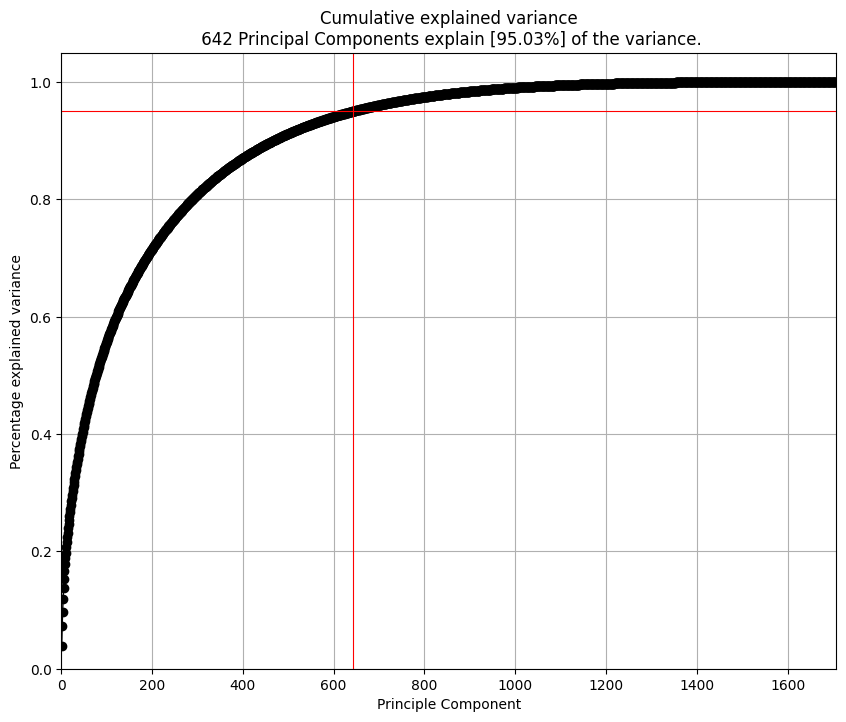

In [7]:
# Screen plot
model.plot(figsize=(10,8))
plt.show()

In [8]:
# Print the top features
pd.set_option('display.max_rows', model.results['topfeat'].shape[0]+1)
top = model.results['topfeat']
best = top.loc[top['type']=='best']
best

<IPython.core.display.Javascript object>

PC   feature   loading  type
0      PC1   ECFP314  0.088367  best
1      PC2   ECFP475 -0.074233  best
2      PC3  ECFP1196  0.082013  best
3      PC4  ECFP1937  0.109312  best
4      PC5  ECFP1010  0.101016  best
5      PC6  ECFP1583  0.087694  best
6      PC7   ECFP591  0.088197  best
7      PC8  ECFP1502  0.114007  best
8      PC9   ECFP175  0.098192  best
9     PC10   ECFP993  0.104760  best
10    PC11   ECFP241  0.082474  best
11    PC12    ECFP27  0.085245  best
12    PC13   ECFP332  0.082931  best
13    PC14  ECFP2005 -0.092090  best
14    PC15   ECFP676  0.107178  best
15    PC16   ECFP755  0.085184  best
16    PC17  ECFP1801  0.080965  best
17    PC18   ECFP811  0.079550  best
18    PC19    ECFP50  0.089590  best
19    PC20  ECFP2029  0.092572  best
20    PC21   ECFP912 -0.087349  best
21    PC22  ECFP1771  0.099213  best
22    PC23   ECFP457 -0.089520  best
23    PC24   ECFP696 -0.089003  best
24    PC25    ECFP76  0.082032  best
25    PC26   ECFP342 -0.081392  best
26    PC27   ECFP353 -0.089570  best
27    PC28  ECFP1318 -0.085908  best
28    PC29   ECFP249 -0.081658  best
29    PC30   ECFP158  0.083496  best
30    PC31  ECFP1265  0.082006  best
31    PC32  ECFP1251  0.090719  best
32    PC33  ECFP1092 -0.076622  best
33    PC34    ECFP56  0.082117  best
34    PC35  ECFP1086  0.092832  best
35    PC36   ECFP597 -0.079589  best
36    PC37   ECFP116  0.105599  best
37    PC38  ECFP1639 -0.084221  best
38    PC39  ECFP1489 -0.080691  best
39    PC40  ECFP1430  0.104440  best
40    PC41  ECFP1857  0.083859  best
41    PC42   ECFP888 -0.089382  best
42    PC43   ECFP350 -0.084322  best
43    PC44   ECFP215  0.079720  best
44    PC45   ECFP419  0.080278  best
45    PC46   ECFP913  0.080858  best
46    PC47  ECFP1940  0.109933  best
47    PC48   ECFP913  0.089671  best
48    PC49  ECFP1697  0.081435  best
49    PC50  ECFP1494  0.080849  best
50    PC51   ECFP871  0.078633  best
51    PC52   ECFP312  0.082470  best
52    PC53  ECFP1695  0.075234  best
53    PC54  ECFP1152 -0.101214  best
54    PC55  ECFP1139  0.076674  best
55    PC56     ECFP1 -0.105437  best
56    PC57  ECFP1152 -0.081624  best
57    PC58   ECFP704  0.087921  best
58    PC59   ECFP624 -0.079267  best
59    PC60   ECFP915  0.082184  best
60    PC61  ECFP1136 -0.085881  best
61    PC62   ECFP427 -0.105188  best
62    PC63  ECFP1152 -0.097445  best
63    PC64   ECFP352 -0.083916  best
64    PC65  ECFP1178  0.077013  best
65    PC66  ECFP1441  0.089296  best
66    PC67   ECFP654  0.076555  best
67    PC68  ECFP2036 -0.086667  best
68    PC69  ECFP1270  0.074253  best
69    PC70  ECFP1479 -0.092243  best
70    PC71   ECFP751  0.078889  best
71    PC72  ECFP1483  0.089107  best
72    PC73  ECFP1408  0.097421  best
73    PC74  ECFP1648  0.083983  best
74    PC75  ECFP1572  0.077056  best
75    PC76  ECFP1531  0.115475  best
76    PC77  ECFP1489  0.082019  best
77    PC78   ECFP913  0.090929  best
78    PC79   ECFP657  0.098109  best
79    PC80   ECFP343  0.084428  best
80    PC81   ECFP715  0.080564  best
81    PC82   ECFP867  0.181106  best
82    PC83  ECFP1084 -0.097584  best
83    PC84   ECFP995  0.103760  best
84    PC85  ECFP1534  0.107719  best
85    PC86  ECFP1860  0.078835  best
86    PC87   ECFP360  0.088771  best
87    PC88   ECFP867  0.079482  best
88    PC89  ECFP1951  0.086435  best
89    PC90   ECFP449  0.082692  best
90    PC91   ECFP367  0.102209  best
91    PC92  ECFP1371  0.083688  best
92    PC93  ECFP1011  0.094151  best
93    PC94  ECFP1464 -0.086231  best
94    PC95  ECFP1536  0.085209  best
95    PC96   ECFP940  0.081934  best
96    PC97   ECFP481  0.084528  best
97    PC98  ECFP1848  0.090347  best
98    PC99  ECFP1001 -0.111733  best
99   PC100  ECFP1427  0.085054  best
100  PC101   ECFP336 -0.079750  best
101  PC102  ECFP1430  0.081501  best
102  PC103   ECFP348  0.087232  best
103  PC104  ECFP1464  0.101391  best
104  PC105   ECFP536 -0.082042  best
105  PC106  ECFP1022 -0.092053  best
106  PC107   ECFP880 -0.085399  best
107  PC108  

[scatterd] >INFO> Create scatterplot


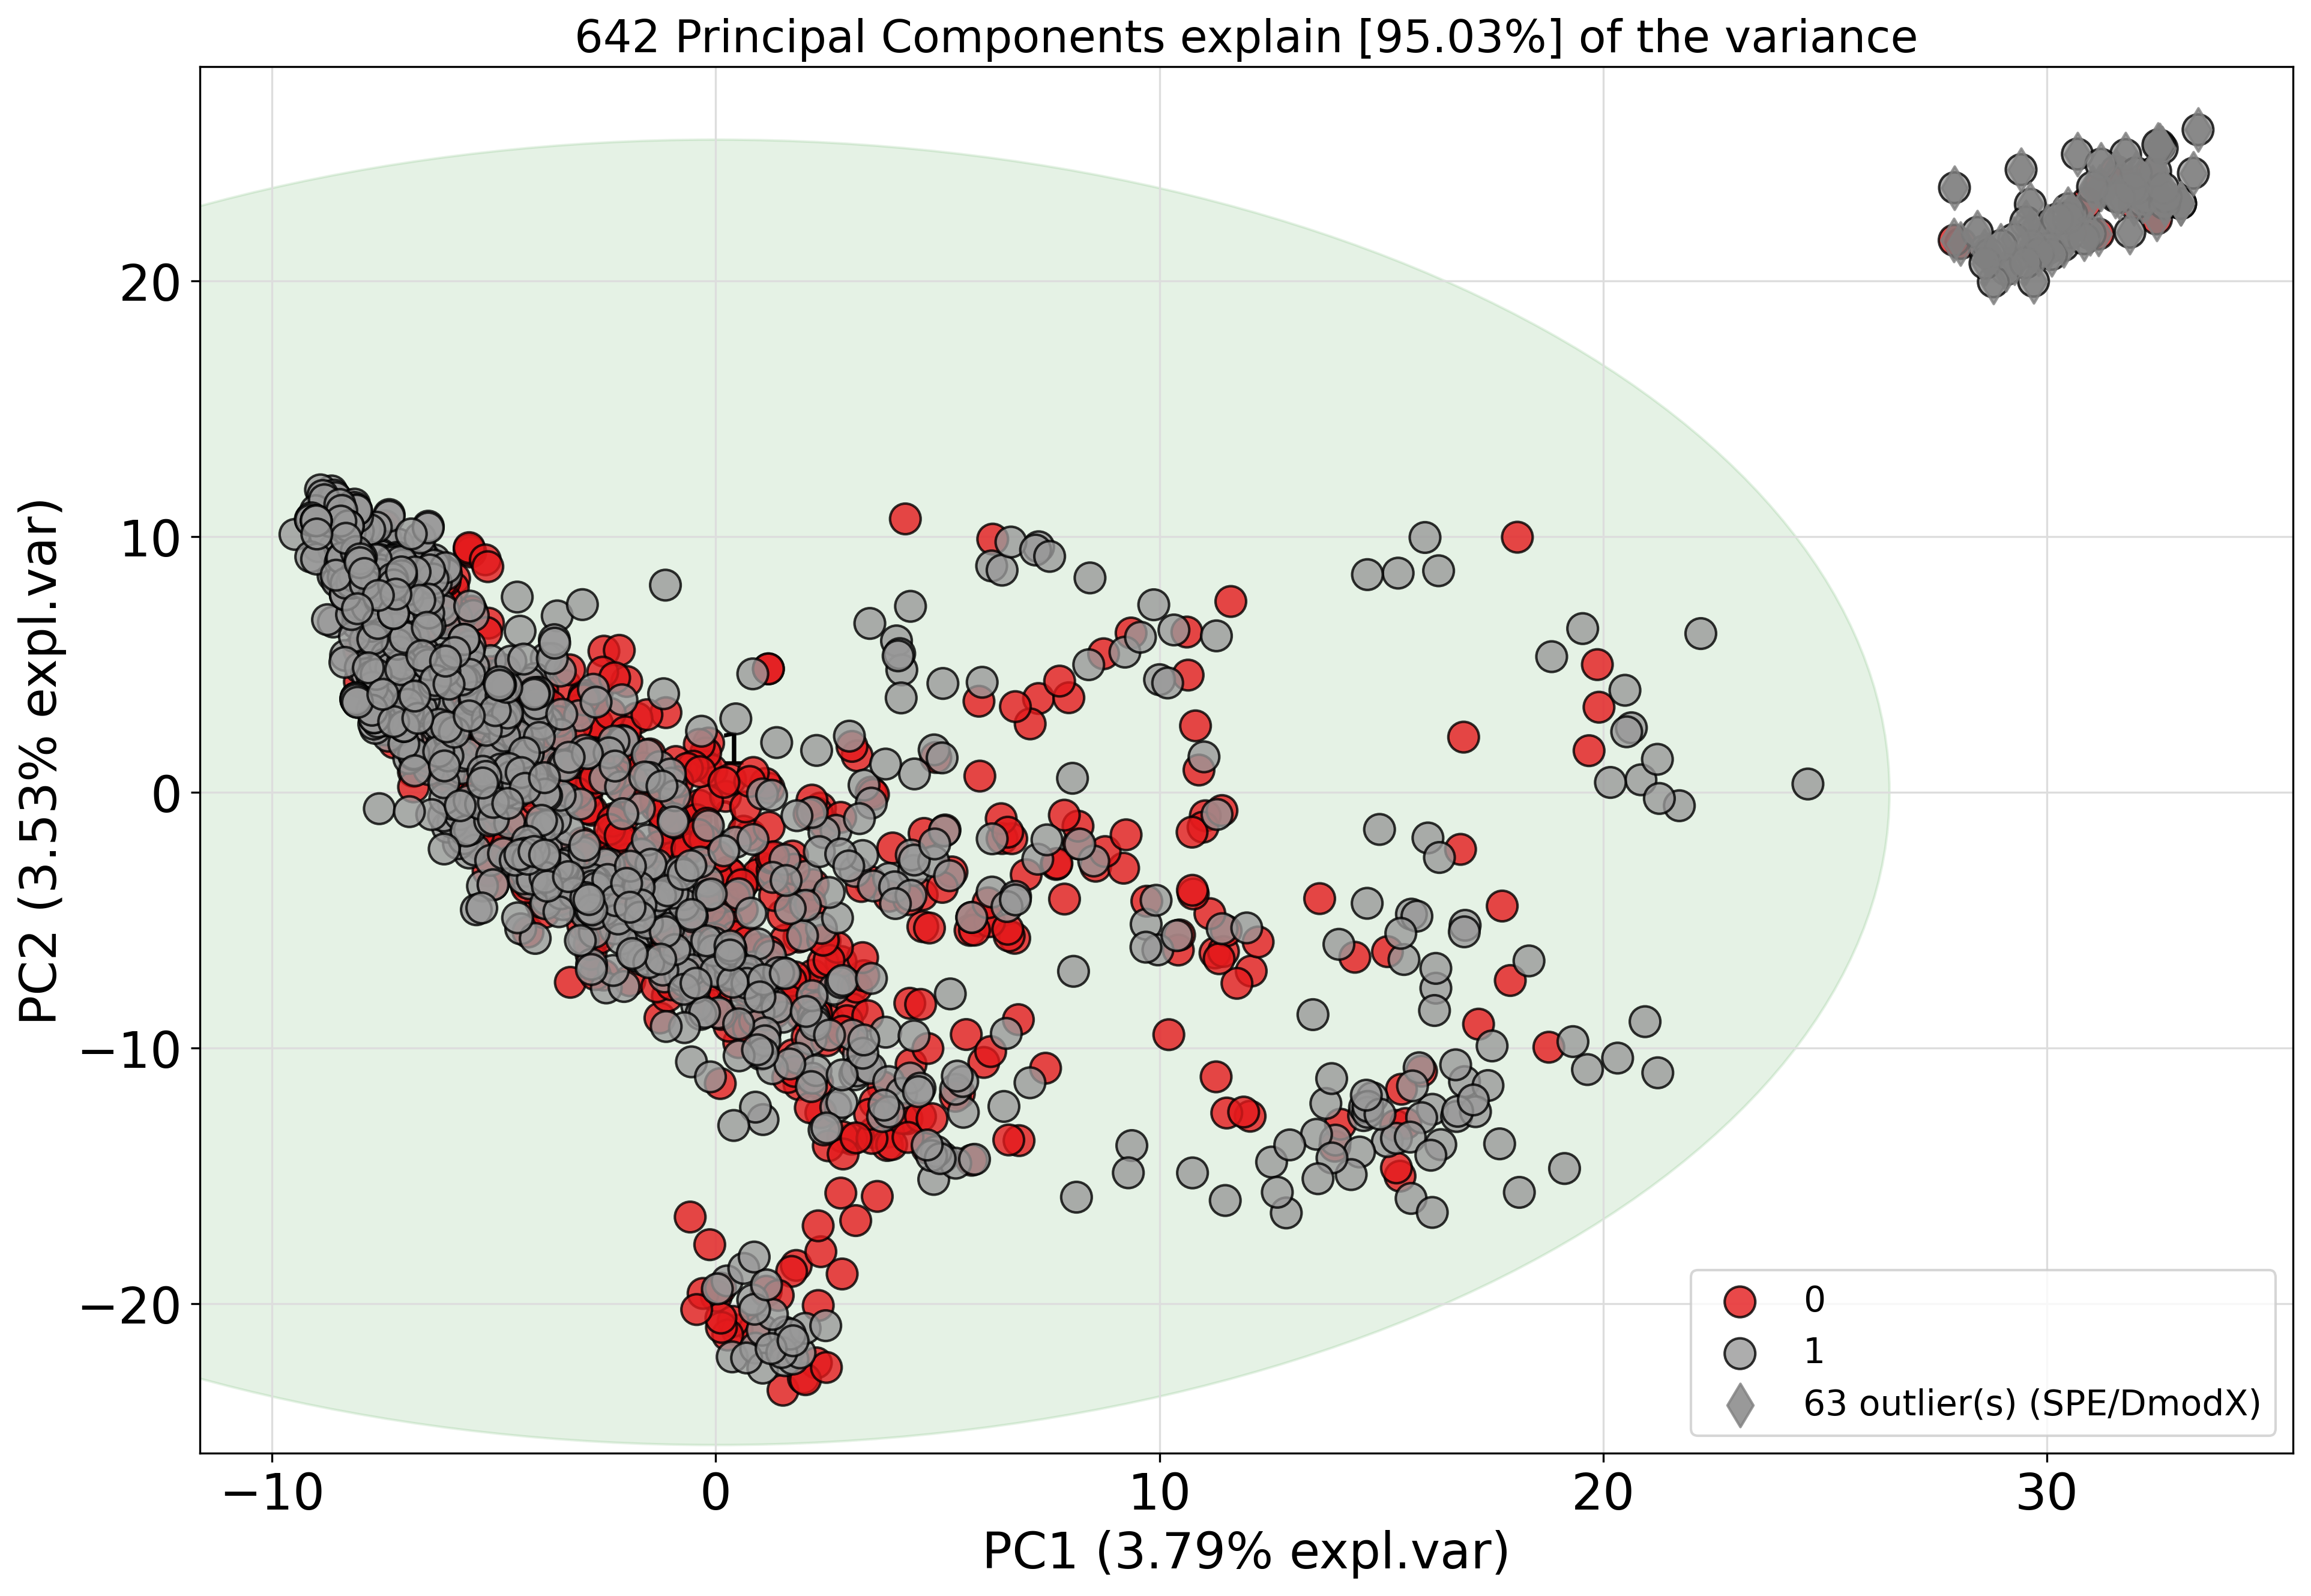

In [11]:
# 2D scatter plot
model.scatter(labels=y, SPE=True, legend=True, cmap='Set1', figsize=(15,10), dpi=300);

[scatterd] >INFO> Create scatterplot


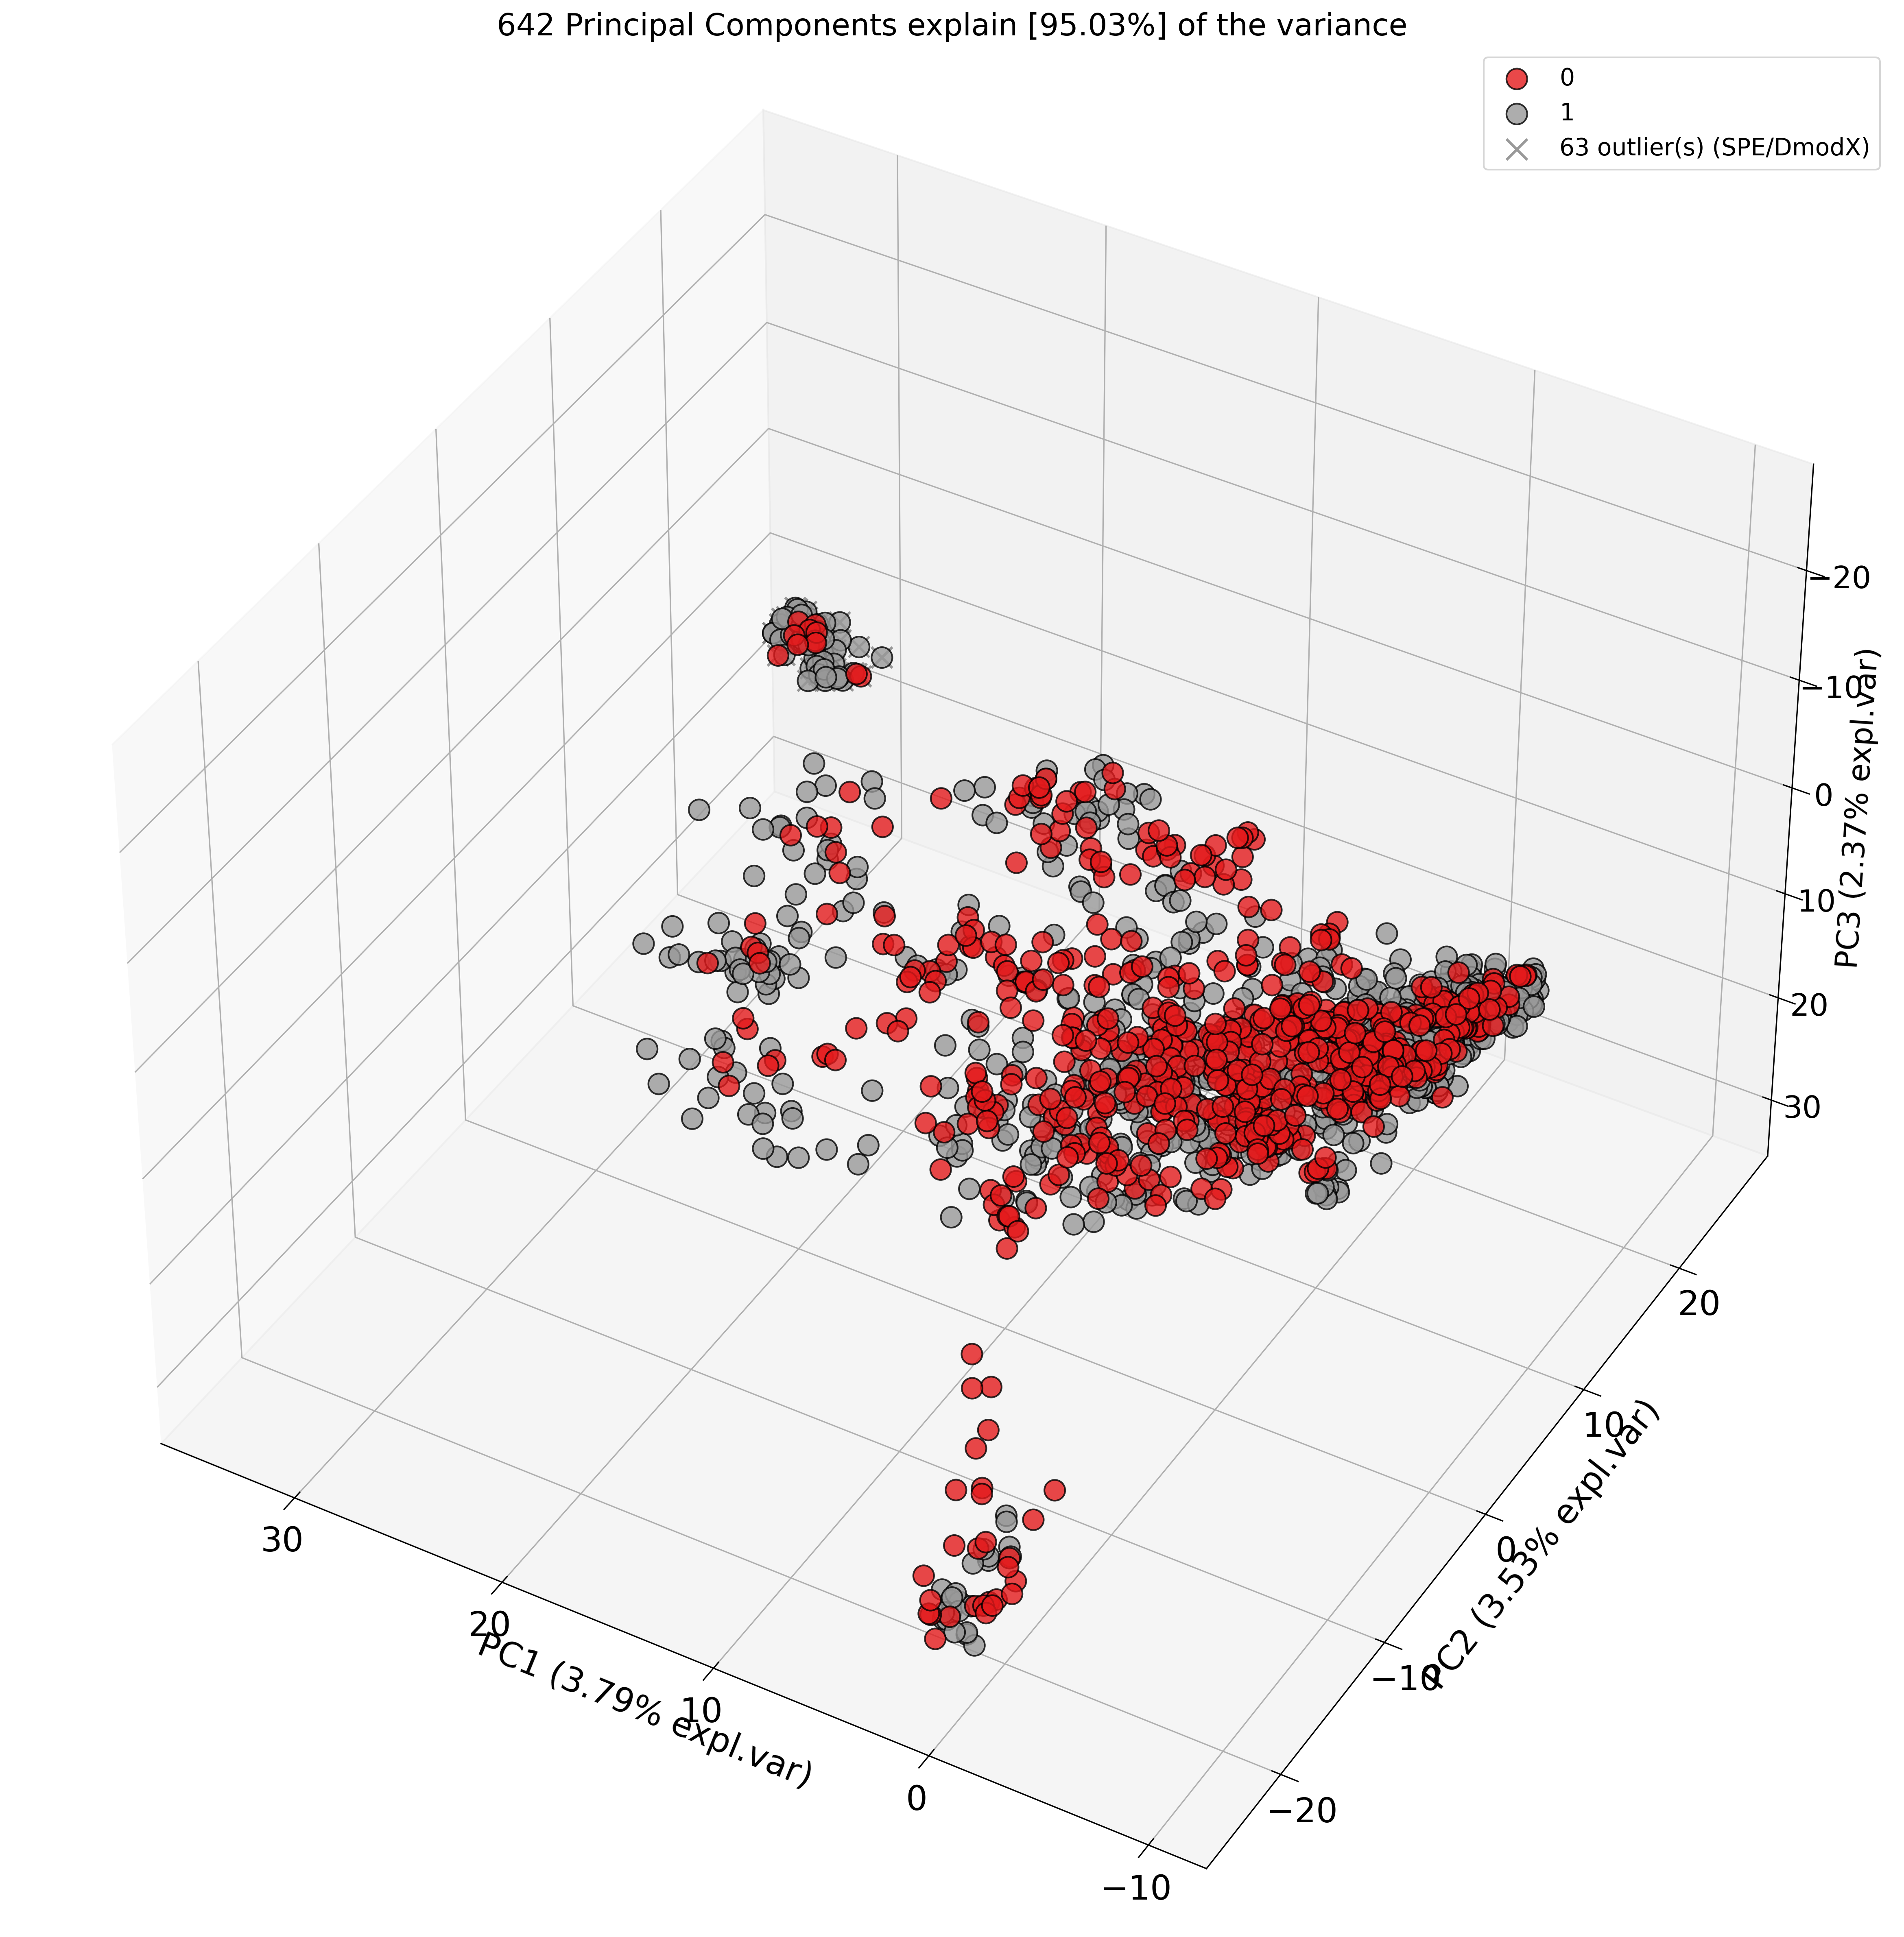

In [12]:
# 3D plot
model.scatter3d(labels=y, SPE=True, legend=True, cmap='Set1', figsize=(30,20), dpi=300);

#**Preprocessing**

In [13]:
# Print the outliers
pd.set_option('display.max_rows', model.results['outliers'].shape[0]+1)
spe = model.results['outliers']
outlier = spe.loc[spe['y_bool_spe']==True]
outlier

<IPython.core.display.Javascript object>

y_proba          p_raw      y_score  y_bool  y_bool_spe  \
190   1.029522e-143  1.919039e-144  3046.144001    True        True   
989   4.317599e-183  7.238180e-184  3349.135331    True        True   
990   2.166528e-200  3.174865e-201  3477.094984    True        True   
991   3.866587e-208  5.326189e-209  3533.519875    True        True   
992   3.866587e-208  5.326189e-209  3533.519875    True        True   
993   2.864849e-200  4.231782e-201  3476.185031    True        True   
994   4.898220e-195  7.608607e-196  3437.742572    True        True   
995   8.076342e-209  1.093573e-209  3538.484673    True        True   
996   1.996955e-178  3.382885e-179  3314.201417    True        True   
1002  8.232730e-214  1.071317e-214  3574.535423    True        True   
1003  1.316572e-165  2.330625e-166  3216.926707    True        True   
1004  1.048342e-195  1.609998e-196  3442.690998    True        True   
1005  1.024144e-206  1.428759e-207  3523.191956    True        True   
1006  1.600978e-205  2.261640e-206  3514.506848    True        True   
1007  1.822051e-187  2.979791e-188  3381.739017    True        True   
1008  3.436282e-179  5.780849e-180  3319.957341    True        True   
1009  4.997603e-217  6.298269e-218  3597.680259    True        True   
1010  1.693296e-208  2.302724e-209  3536.150001    True        True   
1011  1.309201e-212  1.718997e-213  3565.878816    True        True   
1012  2.754787e-200  4.053057e-201  3476.321685    True        True   
1013  7.009281e-170  1.224364e-170  3249.561653    True        True   
1014  6.661301e-175  1.140152e-175  3287.656662    True        True   
1015  6.649904e-173  1.153794e-173  3272.507458    True        True   
1016  1.051272e-221  1.250928e-222  3631.219620    True        True   
1017  3.375986e-234  3.680735e-235  3719.800799    True        True   
1018  1.228940e-206  1.721669e-207  3522.605902    True        True   
1019  3.163172e-203  4.524115e-204  3497.810365    True        True   
1020  2.914881e-173  5.040386e-174  3275.228054    True        True   
1021  2.672347e-202  3.853443e-203  3491.047106    True        True   
1022  1.524957e-206  2.145308e-207  3521.914496    True        True   
1023  6.282268e-200  9.316611e-201  3473.685297    True        True   
1024  2.760109e-216  3.494629e-217  3592.356258    True        True   
1025  2.782593e-215  3.588337e-216  3585.112843    True        True   
1026  9.013534e-226  1.046119e-226  3660.169525    True        True   
1027  3.153979e-217  3.956340e-218  3599.124136    True        True   
1028  1.097344e-227  1.260724e-228  3673.750846    True        True   
1029  5.002792e-205  7.096575e-206  3510.907275    True        True   
1030  1.330220e-167  2.339191e-168  3232.192949    True        True   
1031  4.409908e-156  7.935767e-157  3143.432266    True        True   
1032  5.949966e-179  1.004449e-179  3318.158115    True        True   
1033  7.301133e-154  1.326701e-154  3126.122858    True        True   
1034  2.319282e-173  3.996887e-174  3275.989832    True        True   
1035  2.645009e-166  4.666750e-167  3222.267780    True        True   
1036  1.924316e-196  2.944001e-197  3448.099810    True        True   
1037  6.656075e-171  1.158766e-171  3257.338126    True        True   
1038  2.752870e-183  4.598875e-184  3350.603947    True        True   
1039  5.156689e-208  7.133521e-209  3532.603214    True        True   
1040  5.426711e-187  8.938486e-188  3378.201515    True        True   
1041  1.016008e-189  1.649673e-190  3398.442585    True        True   
1042  4.357393e-174  7.483683e-175  3281.488400    True        True   
1043  1.125007e-193  1.767302e-194  3427.707684    True        True   
1044  2.653425e-195  4.090567e-196  3439.720466    True        True   
1045  1.973739e-201  2.869210e-202  3484.701531    True        True   
1046  1.892183e-211  2.517735e-212  3557.495566    True        True   
1047  6.507241e-229  7.399793e-230  3682.451866    True        True   
1048  5.803783e-213  7.586422e-214  

In [14]:
# Print values to remove
remove = outlier.index.values
remove

array([ 190,  989,  990,  991,  992,  993,  994,  995,  996, 1002, 1003,
       1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014,
       1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025,
       1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036,
       1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047,
       1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055])

In [15]:
data1 = data.drop(data.index[[ 190,  989,  990,  991,  992,  993,  994,  995,  996, 1002, 1003,
       1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014,
       1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025,
       1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036,
       1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047,
       1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055]])

X1 = data1.loc[:, ~data1.columns.isin(['id', 'smiles', 'Saureus'])]
y1 = data1.iloc[:, 2].values
print(X1.shape)
X1.head()

(1643, 2048)


ECFP0  ECFP1  ECFP2  ECFP3  ECFP4  ECFP5  ECFP6  ECFP7  ECFP8  ECFP9  ...  \
0      0      1      0      0      1      0      0      0      1      0  ...   
1      0      1      0      0      0      0      0      0      0      0  ...   
2      0      1      0      0      0      0      0      0      0      0  ...   
3      0      1      0      0      0      0      0      0      0      0  ...   
4      0      1      0      0      0      0      0      0      0      0  ...   

   ECFP2038  ECFP2039  ECFP2040  ECFP2041  ECFP2042  ECFP2043  ECFP2044  \
0         1         0         0         0         0         0         0   
1         0         0         0         1         1         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   ECFP2045  ECFP2046  ECFP2047  
0         0         0         0  
1         0         0         0  
2         0         0         0  
3         0         0         0  
4         0         0         0  

[5 rows x 2048 columns]

In [16]:
# Split dataset into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.20, stratify=y1,
                                                   random_state=42)

print("Size of training set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_test.shape[0]))

<IPython.core.display.Javascript object>

Size of training set: 1314   size of test set: 329



#**Logit**

In [17]:
# Perform random search to optimize parameters for logit
logit = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
param = {'C': np.logspace(-3,3,30)}
logit_cv = RandomizedSearchCV(logit, param, cv=10, n_jobs=-1, random_state=42)
logit_cv.fit(X_train, y_train)

print('best paremeters: ', logit_cv.best_params_)
print('best score after random search cv:', logit_cv.best_score_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best paremeters:  {'C': 0.04520353656360243}
best score after random search cv: 0.7724207726116122


In [18]:
# Zoom on specific values
logit = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
param = {'C': np.linspace(2.8072e-2,7.279e-2,30)}
logit_cv = RandomizedSearchCV(logit, param, cv=10, n_jobs=-1, random_state=42)
logit_cv.fit(X_train, y_train)

print('best paremeters: ', logit_cv.best_params_)
print('best score after random search cv:', logit_cv.best_score_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best paremeters:  {'C': 0.04657599999999999}
best score after random search cv: 0.7716574138329864


In [19]:
# Train logit
logit_tuned = LogisticRegression(max_iter=5000, class_weight='balanced',
                                 C=4.5204e-2, n_jobs=-1, random_state=42)
logit_tuned.fit(X_train, y_train)

# Print intercept & coefficients
print('intercept:', logit_tuned.intercept_)
print('coef:', logit_tuned.coef_, end='\n')

<IPython.core.display.Javascript object>

intercept: [-1.29803919]
coef: [[ 0.0678258  -0.04042311  0.06922881 ... -0.02338538  0.03929263
   0.01410689]]


In [20]:
# Evaluate the logit model on training set
print("Performance of evaluation metrics on training set")
y_train_pred = cross_val_predict(logit_tuned, X_train, y_train, cv=10, n_jobs=-1)
print("MCC score for logit: {:.4f}".format(matthews_corrcoef(y_train, y_train_pred)))
print("ROC-AUC for logit: {:.4f}".format(roc_auc_score(y_train, y_train_pred)))
print("accuracy score for logit: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("kappa score for logit: {:.4f}".format(cohen_kappa_score(y_train, y_train_pred)))
print("f1 score for logit: {:.4f}".format(f1_score(y_train, y_train_pred)))

Performance of evaluation metrics on training set
MCC score for logit: 0.5327
ROC-AUC for logit: 0.7671
accuracy score for logit: 0.7725
kappa score for logit: 0.5327
f1 score for logit: 0.8042


#**KNN**

In [21]:
# Perform random search to optimize parameters for KNN
knn = KNeighborsClassifier()
param = {'n_neighbors': range(5,20), 'weights': ['uniform', 'distance'],
         'leaf_size': range(10,50), 'p': [1,2,3]}
knn_cv = RandomizedSearchCV(knn, param, cv=10, n_jobs=-1, random_state=42)
knn_cv.fit(X_train, y_train)

print('best paremeters: ', knn_cv.best_params_)
print('best score after random search cv:', knn_cv.best_score_)

<IPython.core.display.Javascript object>

best paremeters:  {'weights': 'distance', 'p': 2, 'n_neighbors': 6, 'leaf_size': 34}
best score after random search cv: 0.7617800138792505


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

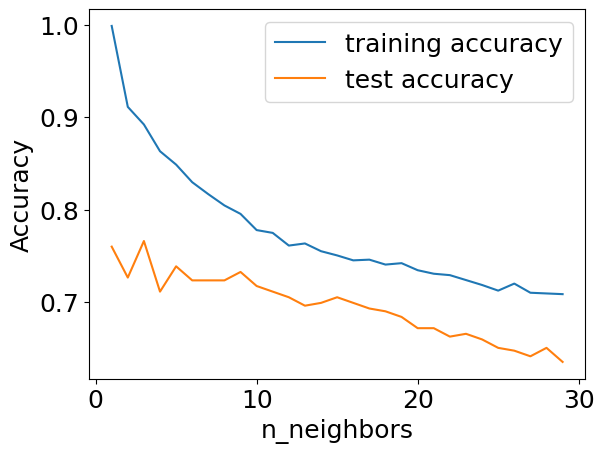

In [22]:
# Find the optimum k
train_acc = []
test_acc = []
# try n_neighbors from 1 to 30
neighbors_settings = range(1, 30)

for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    # record training set accuracy
    train_acc.append(knn.score(X_train, y_train))
    # record generalization accuracy
    test_acc.append(knn.score(X_test, y_test))

plt.plot(neighbors_settings, train_acc, label="training accuracy")
plt.plot(neighbors_settings, test_acc, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [23]:
# Train KNN
knn_tuned = KNeighborsClassifier(n_neighbors=6, weights='distance', leaf_size=34,
                                 p=2, n_jobs=-1)
knn_tuned.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=34, n_jobs=-1, n_neighbors=6, weights='distance')

In [24]:
# Evaluate the KNN model on training set
print("Performance of evaluation metrics on training set")
y_train_pred = cross_val_predict(knn_tuned, X_train, y_train, cv=10, n_jobs=-1)
print("MCC score for KNN: {:.4f}".format(matthews_corrcoef(y_train, y_train_pred)))
print("ROC-AUC for KNN: {:.4f}".format(roc_auc_score(y_train, y_train_pred)))
print("accuracy score for KNN: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("kappa score for KNN: {:.4f}".format(cohen_kappa_score(y_train, y_train_pred)))
print("f1 score for KNN: {:.4f}".format(f1_score(y_train, y_train_pred)))

Performance of evaluation metrics on training set
MCC score for KNN: 0.5033
ROC-AUC for KNN: 0.7457
accuracy score for KNN: 0.7618
kappa score for KNN: 0.5004
f1 score for KNN: 0.8050


#**SVC**

In [25]:
# Perform random search to optimize parameters for SVC
svc = SVC(class_weight='balanced', random_state=42)
param = {'C': np.linspace(0.01,10,20), 'kernel': ['rbf'], 'gamma': np.logspace(-6,1,20)}
svc_cv = RandomizedSearchCV(svc, param, cv=10, n_jobs=-1, random_state=42)
svc_cv.fit(X_train, y_train)

print('best paremeters: ', svc_cv.best_params_)
print('best score after random search cv:', svc_cv.best_score_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best paremeters:  {'kernel': 'rbf', 'gamma': 0.004832930238571752, 'C': 5.267894736842106}
best score after random search cv: 0.8005898681471202


In [26]:
# Zoom on specific values
svc = SVC(class_weight='balanced', random_state=42)
param = {'C': np.linspace(4.7421,5.7937,20), 'kernel': ['rbf'], 'gamma': np.linspace(2.0691e-3,1.1288e-2,20)}
svc_cv = RandomizedSearchCV(svc, param, cv=10, n_jobs=-1, random_state=42)
svc_cv.fit(X_train, y_train)

print('best paremeters: ', svc_cv.best_params_)
print('best score after random search cv:', svc_cv.best_score_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best paremeters:  {'kernel': 'rbf', 'gamma': 0.008861973684210525, 'C': 4.96348947368421}
best score after random search cv: 0.8028568123987971


In [27]:
# Train SVC
svc_tuned = SVC(C=4.9635, kernel='rbf', gamma=8.862e-3, class_weight='balanced',
                probability=True, random_state=42)
svc_tuned.fit(X_train, y_train)

SVC(C=4.9635, class_weight='balanced', gamma=0.008862, probability=True,
    random_state=42)

In [28]:
# Evaluate the SVC model on training set
print("Performance of evaluation metrics on training set")
y_train_pred = cross_val_predict(svc_tuned, X_train, y_train, cv=10, n_jobs=-1)
print("MCC score for SVC: {:.4f}".format(matthews_corrcoef(y_train, y_train_pred)))
print("ROC-AUC for SVC: {:.4f}".format(roc_auc_score(y_train, y_train_pred)))
print("accuracy score for SVC: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("kappa score for SVC: {:.4f}".format(cohen_kappa_score(y_train, y_train_pred)))
print("f1 score for SVC: {:.4f}".format(f1_score(y_train, y_train_pred)))

Performance of evaluation metrics on training set
MCC score for SVC: 0.5906
ROC-AUC for SVC: 0.7912
accuracy score for SVC: 0.8029
kappa score for SVC: 0.5893
f1 score for SVC: 0.8362


#**RF**

In [29]:
# Perform random search to optimize parameters for RF
forest = RandomForestClassifier(class_weight='balanced', random_state=42)
param = {'n_estimators': np.linspace(100,1200,20).astype(int),
         'criterion': ['gini', 'entropy'],
         'max_depth': np.linspace(5,30,20).astype(int),
         'max_features':['sqrt', 'log2', None]}
forest_cv = RandomizedSearchCV(forest, param, n_jobs=-1, cv=10, random_state=42)
forest_cv.fit(X_train, y_train)

print('best paremeters: ', forest_cv.best_params_)
print('best score after random search cv:', forest_cv.best_score_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best paremeters:  {'n_estimators': 1142, 'max_features': 'sqrt', 'max_depth': 14, 'criterion': 'entropy'}
best score after random search cv: 0.80058986814712


In [30]:
# Zoom on specific values
forest = RandomForestClassifier(class_weight='balanced', random_state=42)
param = {'n_estimators': range(1084,1200),
         'criterion': ['entropy'],
         'max_depth': range(10,20),
         'max_features':['sqrt']}
forest_cv = RandomizedSearchCV(forest, param, n_jobs=-1, cv=10, random_state=42)
forest_cv.fit(X_train, y_train)

print('best paremeters: ', forest_cv.best_params_)
print('best score after random search cv:', forest_cv.best_score_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

best paremeters:  {'n_estimators': 1182, 'max_features': 'sqrt', 'max_depth': 12, 'criterion': 'entropy'}
best score after random search cv: 0.8029030765671987


In [31]:
# Train RF
forest_tuned = RandomForestClassifier(n_estimators=1182, criterion='entropy', max_depth=12,
                                      max_features='sqrt', class_weight='balanced',
                                      n_jobs=-1, random_state=42)
forest_tuned.fit(X_train, y_train)

<IPython.core.display.Javascript object>

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, n_estimators=1182, n_jobs=-1,
                       random_state=42)

In [32]:
# Evaluate the RF model on training set
print("Performance of evaluation metrics on training set")
y_train_pred = cross_val_predict(forest_tuned, X_train, y_train, cv=10, n_jobs=-1)
print("MCC score for RF: {:.4f}".format(matthews_corrcoef(y_train, y_train_pred)))
print("ROC-AUC for RF: {:.4f}".format(roc_auc_score(y_train, y_train_pred)))
print("accuracy score for RF: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("kappa score for RF: {:.4f}".format(cohen_kappa_score(y_train, y_train_pred)))
print("f1 score for RF: {:.4f}".format(f1_score(y_train, y_train_pred)))

Performance of evaluation metrics on training set
MCC score for RF: 0.5917
ROC-AUC for RF: 0.7937
accuracy score for RF: 0.8029
kappa score for RF: 0.5913
f1 score for RF: 0.8343


#**XGB**

In [ ]:
# Perform random search to optimize parameters for XGB
xgb = XGBClassifier(objective='binary:logistic', scale_pos_weight=1, random_state=42)
param = {'learning_rate': np.logspace(-3,0,20),
         'n_estimators': np.linspace(100,1200,20).astype(int),
         'gamma': np.logspace(-6,1,20),
         'max_depth': np.linspace(5,30,20).astype(int),
         'subsample': np.linspace(0,1,20),
         'colsample_bytree': np.linspace(0,1,20),
         'alpha': np.logspace(-3,3,20)}
xgb_cv = RandomizedSearchCV(xgb, param, cv=10, random_state=42)
xgb_cv.fit(X_train, y_train)

print('best paremeters: ', xgb_cv.best_params_)
print('best score after random search cv:', xgb_cv.best_score_)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Zoom on specific values
xgb = XGBClassifier(objective='binary:logistic', scale_pos_weight=1, random_state=42)
param = {'learning_rate': np.linspace(1.2743e-2,2.6367e-2,20),
         'n_estimators': range(505,621),
         'gamma': np.linspace(1.6238e-4,8.8587e-4,20),
         'max_depth': range(25,30),
         'subsample': np.linspace(8.9474e-1,1.0,20),
         'colsample_bytree': np.linspace(4.2105e-1,5.2632e-1,20),
         'alpha': np.linspace(6.9519e-1,2.9764,20)}
xgb_cv = RandomizedSearchCV(xgb, param, cv=10, random_state=42)
xgb_cv.fit(X_train, y_train)

print('best paremeters: ', xgb_cv.best_params_)
print('best score after random search cv:', xgb_cv.best_score_)

In [ ]:
# Train XGB
xgb_tuned = XGBClassifier(objective='binary:logistic', scale_pos_weight=1, learning_rate=2.4933e-2,
                          n_estimators=617, gamma=7.3356e-4, max_depth=28, subsample=9.723e-1,
                          colsample_bytree=4.7091e-1, alpha=1.6557, random_state=42)
xgb_tuned.fit(X_train, y_train)

In [ ]:
# Evaluate the XGB model on training set
print("Performance of evaluation metrics on training set")
y_train_pred = cross_val_predict(xgb_tuned, X_train, y_train, cv=10)
print("MCC score for XGB: {:.4f}".format(matthews_corrcoef(y_train, y_train_pred)))
print("ROC-AUC for XGB: {:.4f}".format(roc_auc_score(y_train, y_train_pred)))
print("accuracy score for XGB: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("kappa score for XGB: {:.4f}".format(cohen_kappa_score(y_train, y_train_pred)))
print("f1 score for XGB: {:.4f}".format(f1_score(y_train, y_train_pred)))

#**LGBM**

In [ ]:
# Perform random search to optimize parameters for LGBM
lgbm = LGBMClassifier(device='cpu', objective='binary', is_unbalance=True, bagging_freq=1,
                      verbose=-1, random_state=42)
param = {'n_estimators': np.linspace(100,1200,20).astype(int),
         'learning_rate': np.logspace(-3,0,20),
         'num_leaves': np.linspace(10,300,20).astype(int),
         'max_depth': range(5,30),
         'min_data_in_leaf': np.linspace(20,300,20).astype(int),
         'bagging_fraction': np.linspace(0.5,0.9,5),
         'feature_fraction': np.linspace(0.5,0.9,5)}
lgbm_cv = RandomizedSearchCV(lgbm, param, cv=10, random_state=42)
lgbm_cv.fit(X_train, y_train)

print('best paremeters: ', lgbm_cv.best_params_)
print('best score after random search cv:', lgbm_cv.best_score_)

In [ ]:
# Zoom on specific values
lgbm = LGBMClassifier(device='cpu', objective='binary', is_unbalance=True, bagging_freq=1,
                      verbose=-1, random_state=42)
param = {'n_estimators': range(852,969),
         'learning_rate': np.linspace(1.6238e-1,3.3598e-1,20),
         'num_leaves': range(177,208),
         'max_depth': range(10,20),
         'min_data_in_leaf': range(78,108),
         'bagging_fraction': np.linspace(0.5,0.9,5),
         'feature_fraction': np.linspace(0.5,0.9,5)}
lgbm_cv = RandomizedSearchCV(lgbm, param, cv=10, random_state=42)
lgbm_cv.fit(X_train, y_train)

print('best paremeters: ', lgbm_cv.best_params_)
print('best score after random search cv:', lgbm_cv.best_score_)

In [ ]:
# Train LGBM
lgbm_tuned = LGBMClassifier(device='cpu', objective='binary', is_unbalance=True,
                            n_estimators=860, learning_rate=2.6289e-1, num_leaves=195,
                            max_depth=15, min_data_in_leaf=104, bagging_fraction=0.9,
                            bagging_freq=1, feature_fraction=0.9, verbose=-1, random_state=42)
lgbm_tuned.fit(X_train, y_train)

In [ ]:
# Evaluate the LGBM model on training set
print("Performance of evaluation metrics on training set")
y_train_pred = cross_val_predict(lgbm_tuned, X_train, y_train, cv=10)
print("MCC score for LGBM: {:.4f}".format(matthews_corrcoef(y_train, y_train_pred)))
print("ROC-AUC for LGBM: {:.4f}".format(roc_auc_score(y_train, y_train_pred)))
print("accuracy score for LGBM: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("kappa score for LGBM: {:.4f}".format(cohen_kappa_score(y_train, y_train_pred)))
print("f1 score for LGBM: {:.4f}".format(f1_score(y_train, y_train_pred)))

#**Voting**

In [ ]:
# Train voting model
vote = VotingClassifier(estimators=[('svc', svc_tuned), ('rf', forest_tuned)], voting='soft')

vote.fit(X_train, y_train)

In [ ]:
# Evaluate the voting model on training set
print("Performance of evaluation metrics on training set")
y_train_pred = cross_val_predict(vote, X_train, y_train, cv=10)
print("MCC score for voting: {:.4f}".format(matthews_corrcoef(y_train, y_train_pred)))
print("ROC-AUC for voting: {:.4f}".format(roc_auc_score(y_train, y_train_pred)))
print("accuracy score for voting: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("kappa score for voting: {:.4f}".format(cohen_kappa_score(y_train, y_train_pred)))
print("f1 score for voting: {:.4f}".format(f1_score(y_train, y_train_pred)))

#**Stacking**

In [ ]:
# Train stacking model
stack = StackingClassifier(estimators=[('svc', svc_tuned), ('rf', forest_tuned)])

stack.fit(X_train, y_train)

In [ ]:
# Evaluate the stacking model on training set
print("Performance of evaluation metrics on training set")
y_train_pred = cross_val_predict(stack, X_train, y_train, cv=10)
print("MCC score for stacking: {:.4f}".format(matthews_corrcoef(y_train, y_train_pred)))
print("ROC-AUC for stacking: {:.4f}".format(roc_auc_score(y_train, y_train_pred)))
print("accuracy score for stacking: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
print("kappa score for stacking: {:.4f}".format(cohen_kappa_score(y_train, y_train_pred)))
print("f1 score for stacking: {:.4f}".format(f1_score(y_train, y_train_pred)))

#**PR curves**

In [ ]:
# Plot PR curve for logit model
y_thres = logit_tuned.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_thres)
def plot_PR_curve(precision, recall, label=None):
    plt.plot(precision, recall, linewidth=2, label=label)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.grid()
plot_PR_curve(precision, recall)

In [ ]:
# Compare ROC curve for all models
y_proba_knn = knn_tuned.predict_proba(X_test)[:, 1]
y_thres_svc = svc_tuned.decision_function(X_test)
y_proba_forest = forest_tuned.predict_proba(X_test)[:, 1]
y_proba_xgb = xgb_tuned.predict_proba(X_test)[:, 1]
y_proba_lgbm = lgbm_tuned.predict_proba(X_test)[:, 1]
y_proba_vote = vote.predict_proba(X_test)[:, 1]
y_proba_stack = stack.predict_proba(X_test)[:, 1]

precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_test, y_proba_knn)
precision_svc, recall_svc, thresholds_svc = precision_recall_curve(y_test, y_thres_svc)
precision_forest, recall_forest, thresholds_forest = precision_recall_curve(y_test, y_proba_forest)
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_proba_xgb)
precision_lgbm, recall_lgbm, thresholds_lgbm = precision_recall_curve(y_test, y_proba_lgbm)
precision_vote, recall_vote, thresholds_vote = precision_recall_curve(y_test, y_proba_vote)
precision_stack, recall_stack, thresholds_stack = precision_recall_curve(y_test, y_proba_stack)

plt.figure(figsize=(7, 6))
plt.plot(precision, recall, "b:", label="logit")
plot_PR_curve(precision_knn, recall_knn, "KNN")
plot_PR_curve(precision_svc, recall_svc, "SVC")
plot_PR_curve(precision_forest, recall_forest, "RF")
plot_PR_curve(precision_xgb, recall_xgb, "XGB")
plot_PR_curve(precision_lgbm, recall_lgbm, "LGBM")
plot_PR_curve(precision_vote, recall_vote, "vote")
plot_PR_curve(precision_stack, recall_stack, "stack")

plt.legend(loc="best")

#**ROC curves**

In [ ]:
# Plot ROC curve for logit model
fpr, tpr, thresholds = roc_curve(y_test, y_thres)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.grid()
plot_roc_curve(fpr, tpr)

In [ ]:
# Compare ROC curve for all models
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_proba_knn)
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_thres_svc)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, y_proba_forest)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_proba_xgb)
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, y_proba_lgbm)
fpr_vote, tpr_vote, thresholds_vote = roc_curve(y_test, y_proba_vote)
fpr_stack, tpr_stack, thresholds_stack = roc_curve(y_test, y_proba_stack)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, "b:", label="logit")
plot_roc_curve(fpr_knn, tpr_knn, "KNN")
plot_roc_curve(fpr_svc, tpr_svc, "SVC")
plot_roc_curve(fpr_forest, tpr_forest, "RF")
plot_roc_curve(fpr_xgb, tpr_xgb, "XGB")
plot_roc_curve(fpr_lgbm, tpr_lgbm, "LGBM")
plot_roc_curve(fpr_vote, tpr_vote, "vote")
plot_roc_curve(fpr_stack, tpr_stack, "stack")

plt.legend(loc="lower right")

#**Evaluation**

In [ ]:
# Evaluate the stacking model on test set
y_pred_stack = stack.predict(X_test)
y_proba_stack = stack.predict_proba(X_test)[:, 1]
print("Performance of evaluation metrics on test set")
print("accuracy score for SVC: {:.4f}".format(accuracy_score(y_test, y_pred_svc)))
print("kappa score for SVC: {:.4f}".format(cohen_kappa_score(y_test, y_pred_svc)))
print("precision score for SVC: {:.4f}".format(precision_score(y_test, y_pred_svc)))
print("sensitivity score for SVC: {:.4f}".format(recall_score(y_test, y_pred_svc)))
print("ROC-AUC for SVC: {:.4f}".format(roc_auc_score(y_test, y_thres_svc)))
print("f1 score for SVC: {:.4f}".format(f1_score(y_test, y_pred_svc)))
print("MCC score for SVC: {:.4f}".format(matthews_corrcoef(y_test, y_pred_svc)))

In [ ]:
# Plot confusion matrix for the stacking model
cm = confusion_matrix(y_test, y_pred_stack, labels= stack.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stack.classes_)
disp.plot()

In [ ]:
# Visualize observations that were incorrectly labeled
Flabel = pd.DataFrame(X_test[y_test != y_pred_stack])
Flabel